In [1]:
# pip install lightgbm
# pip install ipywidgets

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [136]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier
import xgboost as xgb

try:
    # To enable interactive mode you should install ipywidgets
    # pip install ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

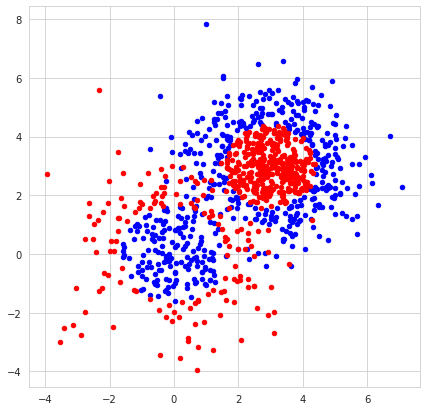

In [112]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(7,7))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='binary')

metrics = ['binary_logloss','auc']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 10,
          verbose = 10,
          feature_name = ['X','Y'])

Training until validation scores don't improve for 10 rounds
[10]	Training data's binary_logloss: 0.38034	Training data's auc: 0.956459	Test data's binary_logloss: 0.445584	Test data's auc: 0.89775
[20]	Training data's binary_logloss: 0.282957	Training data's auc: 0.973516	Test data's binary_logloss: 0.362354	Test data's auc: 0.9324
[30]	Training data's binary_logloss: 0.23252	Training data's auc: 0.982056	Test data's binary_logloss: 0.318371	Test data's auc: 0.93965
[40]	Training data's binary_logloss: 0.204727	Training data's auc: 0.984878	Test data's binary_logloss: 0.298425	Test data's auc: 0.94505
[50]	Training data's binary_logloss: 0.179179	Training data's auc: 0.988766	Test data's binary_logloss: 0.276923	Test data's auc: 0.9493
[60]	Training data's binary_logloss: 0.161444	Training data's auc: 0.990828	Test data's binary_logloss: 0.264285	Test data's auc: 0.95305
[70]	Training data's binary_logloss: 0.146458	Training data's auc: 0.992147	Test data's binary_logloss: 0.25154	Tes

LGBMClassifier(max_depth=4, num_leaves=7, objective='binary')

In [114]:
def render_metric(metric_name):
    ax = lgb.plot_metric(model.evals_result_, metric=metric_name, figsize=(10, 5))
    plt.show()
    
def plot_metrics():
    if INTERACTIVE:
        # create widget to switch between metrics
        interact(render_metric, metric_name=metrics)
    else:
        for metric in metrics:
            render_metric(metric)

In [115]:
plot_metrics()

interactive(children=(Dropdown(description='metric_name', options=('binary_logloss', 'auc'), value='binary_log…

In [116]:
ypred = model.predict(X_test)

matrix = confusion_matrix(y_test, ypred)
print(matrix)

print(model.score(X_test, y_test))

[[93  7]
 [16 84]]
0.885


In [117]:
def plot_decision_boundary(model, X, y, fig_size=(7,7)):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = model.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure(figsize=fig_size)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = model.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b',s=20)
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v',s=20)
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r',s=20)
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v',s=20)
    plt.show()

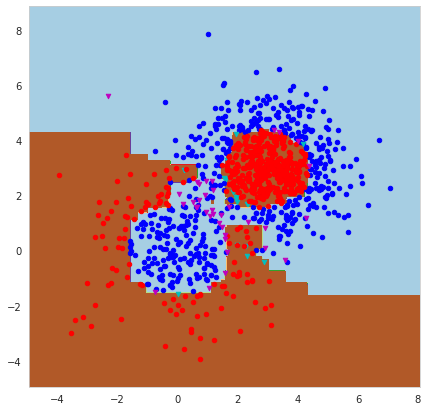

In [118]:
plot_decision_boundary(model,X,y)

In [119]:
def render_tree(tree_index, show_info, precision=3):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(model, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

def plot_trees():
    if INTERACTIVE:
        # create widget to switch between trees and control info in nodes
        interact(render_tree,
                 tree_index=(0, model.best_iteration_ - 1),
                 show_info=SelectMultiple(  # allow multiple values to be selected
                     options=['None',
                              'split_gain',
                              'internal_count',
                              'data_percentage'],
                     value=['None']),
                 precision=(0, 4))
        tree = None
    else:
        tree = render_tree(53, ['None'])
    
    tree

In [121]:
plot_trees()

interactive(children=(IntSlider(value=49, description='tree_index', max=99), SelectMultiple(description='show_…

## Examples

#### NIST

In [122]:
from sklearn import datasets

digits = datasets.load_digits()
#print(digits.DESCR)

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [123]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.441867	Test data's multi_logloss: 0.592283
[20]	Training data's multi_logloss: 0.140464	Test data's multi_logloss: 0.305901
[30]	Training data's multi_logloss: 0.0491627	Test data's multi_logloss: 0.205292
[40]	Training data's multi_logloss: 0.0186713	Test data's multi_logloss: 0.162669
[50]	Training data's multi_logloss: 0.00750826	Test data's multi_logloss: 0.137057
[60]	Training data's multi_logloss: 0.00314839	Test data's multi_logloss: 0.124264
[70]	Training data's multi_logloss: 0.00135547	Test data's multi_logloss: 0.11431
[80]	Training data's multi_logloss: 0.000589546	Test data's multi_logloss: 0.109725
Early stopping, best iteration is:
[84]	Training data's multi_logloss: 0.000423805	Test data's multi_logloss: 0.108984


LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [124]:
plot_metrics()
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Genralization score : 0.967


#### Wine

In [125]:
wine = datasets.load_wine()
#print(wine.DESCR)

X = wine.data
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [126]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.326111	Test data's multi_logloss: 0.396826
[20]	Training data's multi_logloss: 0.122718	Test data's multi_logloss: 0.189284
[30]	Training data's multi_logloss: 0.0480493	Test data's multi_logloss: 0.101701
[40]	Training data's multi_logloss: 0.0180464	Test data's multi_logloss: 0.0616918
[50]	Training data's multi_logloss: 0.0071092	Test data's multi_logloss: 0.0422292
[60]	Training data's multi_logloss: 0.00291314	Test data's multi_logloss: 0.0330035
[70]	Training data's multi_logloss: 0.00117456	Test data's multi_logloss: 0.0244714
[80]	Training data's multi_logloss: 0.000474824	Test data's multi_logloss: 0.0185733
[90]	Training data's multi_logloss: 0.000190751	Test data's multi_logloss: 0.0163887
[100]	Training data's multi_logloss: 7.75404e-05	Test data's multi_logloss: 0.0147851
Did not meet early stopping. Best iteration is:
[100]	Training data's multi_logloss: 7.75404e-05	Test data

LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [127]:
plot_metrics()
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Genralization score : 1.0


## Comparaison XGBoost et LightGBM

# A complete exemple : Classification of stars, Galaxies, Quasars

For this first application of XGBoost, we will try to classify observations of space to be either stars, galaxies or quasars.
We are using data from the [Sloan Digital Sky Survey](http://www.sdss.org/)

### About the SDSS
The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [128]:
sdss_df = pd.read_csv('./data/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


In [129]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

## Data Analysis

Before applying any classification algorithm, let's look a bit more and transform the data : first we remove the column that obviously won't help classify into the correct class, such as the objects id and parameters of the camera at the moment of observation.

In [130]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


Next we look at a few interesting features (univariate analysis) : by plotting the distribution of each class along this feature, we can estimate if this feature can help in classifying the data.

For instance, we can see that redshift seems to have good correlation, while declination does not differ significantly between the 3 classes.

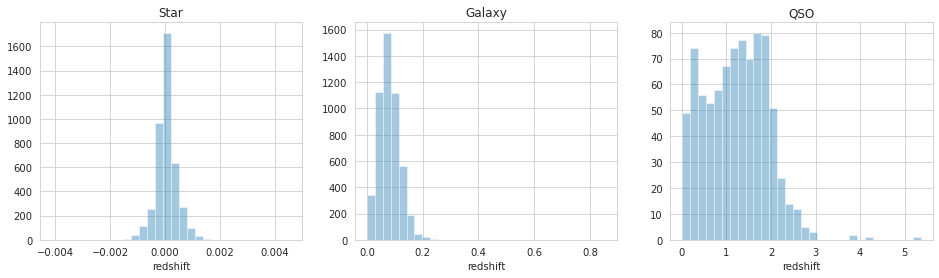

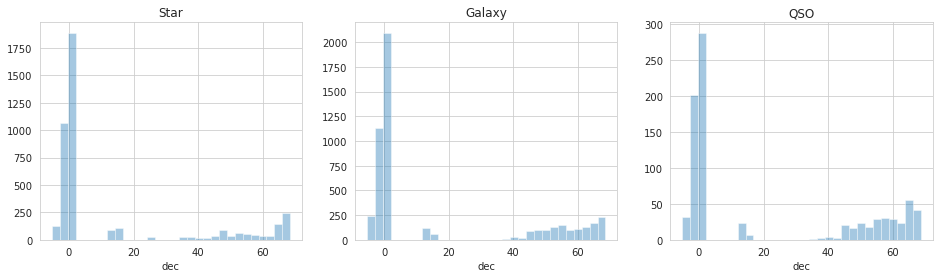

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].dec, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].dec, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].dec, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Finally, we transform a few features : we transform the different bands through a PCA, we encode the classes and scale the extreme values.

In [132]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [133]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

## Classification

We will try to tune the parameters of the classificator :

In [165]:
X_train, X_test, y_train, y_test = train_test_split(sdss,y_encoded, test_size=0.2)

In [166]:
from sklearn.model_selection import GridSearchCV

def tune_param(rate):

    model = LGBMClassifier(boosting_type='gbdt',
                           learning_rate = rate,
                           objective='multiclass')

    param_test = {
     'num_leaves':[3,5,7,9],
     'max_depth':[1,3,5,7],
     'n_estimators':[50,100,200]
    }
    
    gsearch1 = GridSearchCV(estimator = model, param_grid = param_test, cv=10)
    gsearch1.fit(X_train, y_train)
    
    print("Best parameters: ", gsearch1.best_params_)
    print("Best score: ", gsearch1.best_score_)
    
    return gsearch1.best_params_

rate=0.1
best_params = tune_param(rate)

In [167]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = best_params['num_leaves'],
                       max_depth = best_params['max_depth'],
                       learning_rate = 0.1,
                       n_estimators = best_params['n_estimators'],
                       objective='multiclass')

metrics = ['multi_logloss']

start = time.time()

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 20,
          verbose = 10)

end = time.time()

Best parameters:  {'max_depth': 5, 'n_estimators': 100, 'num_leaves': 7}
Best score:  0.9925
Training until validation scores don't improve for 20 rounds
[10]	Training data's multi_logloss: 0.1966	Test data's multi_logloss: 0.192665
[20]	Training data's multi_logloss: 0.0688686	Test data's multi_logloss: 0.0641437
[30]	Training data's multi_logloss: 0.0352129	Test data's multi_logloss: 0.0317917
[40]	Training data's multi_logloss: 0.0234767	Test data's multi_logloss: 0.0229646
[50]	Training data's multi_logloss: 0.0170465	Test data's multi_logloss: 0.0204853
[60]	Training data's multi_logloss: 0.0132597	Test data's multi_logloss: 0.0196298
[70]	Training data's multi_logloss: 0.0105492	Test data's multi_logloss: 0.0193335
[80]	Training data's multi_logloss: 0.00859034	Test data's multi_logloss: 0.0190341
[90]	Training data's multi_logloss: 0.0071225	Test data's multi_logloss: 0.0190953
[100]	Training data's multi_logloss: 0.00599555	Test data's multi_logloss: 0.0185588
Did not meet earl

In [168]:
plot_metrics()
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Generalization score : {}'.format(round(model.score(X_test,y_test),3)))
print('Elapsed time : {}s'.format(round(end-start,3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 0.999
Generalization score : 0.994
Elapsed time : 0.203s


In [170]:
num_round = 100
param = {
    "learning_rate" :0.1,
    "n_estimators":1000,
    'objective': 'multiclass'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(param, dtrain, num_round, early_stopping_rounds=20)
preds = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in preds])
print (precision_score(y_test, predictions, average='macro'))

XGBoostError: [16:06:29] ../src/objective/objective.cc:26: Unknown objective function: `multiclass`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: reg:pseudohubererror
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie

Stack trace:
  [bt] (0) /home/cdrutinus/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x20b683) [0x7f0f23dcb683]
  [bt] (1) /home/cdrutinus/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1af06c) [0x7f0f23d6f06c]
  [bt] (2) /home/cdrutinus/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1bc162) [0x7f0f23d7c162]
  [bt] (3) /home/cdrutinus/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1a29cb) [0x7f0f23d629cb]
  [bt] (4) /home/cdrutinus/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x58) [0x7f0f23c400c8]
  [bt] (5) /home/cdrutinus/anaconda3/lib/python3.8/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f0f99c669dd]
  [bt] (6) /home/cdrutinus/anaconda3/lib/python3.8/lib-dynload/../../libffi.so.7(+0x6067) [0x7f0f99c66067]
  [bt] (7) /home/cdrutinus/anaconda3/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x1097a) [0x7f0f990de97a]
  [bt] (8) /home/cdrutinus/anaconda3/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x110db) [0x7f0f990df0db]

